In [7]:
import gym
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.optimizers import Adam
from keras import optimizers
from collections import deque 
%matplotlib inline


class DQNAgent():

    def __init__(self, state_size, action_size):
        self.state_size = state_size  
        self.action_size = action_size 

        self.discount_factor = 0.9
        self.learning_rate = 0.001
        self.epsilon = 0.1
        self.epsilon_decay_factor = 0.99 #ยิ่ง while loop discount ต้องลดช้าลง 0.9999
        self.epsilon_min = 0.01

        # Experience Replay technic คนละ Weight
        self.model = self.build_model()  # ใช้หา 1.Optimal action ในแต่ละ timestep, 2.ใช้คำนวน Q(s,a) ใน loss function
        self.target_model = self.build_model()  # Target model ใช้คำนวน (r + gamma * maxQ(s',a))

        self.update_target_model()

        self.memory = deque(maxlen=1000)  # memory for train
        self.batch_size = 100

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        optimal_action = np.argmax(self.model.predict(state)[0])
        random_action = random.randint(0, self.action_size - 1)
        action = np.random.choice([optimal_action, random_action], p=[1 - self.epsilon, self.epsilon])
        return action

    def build_model(self):
        model = Sequential()
        model.add(Dense(120, input_dim=self.state_size, activation='relu'))
        model.add(Dense(120, activation='relu'))
        model.add(Dense(120, activation='relu'))
        model.add(Dense(120, activation='relu'))
        model.add(Dense(units=self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def save_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_factor

    def train_model(self):
        if len(self.memory) >= self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)  # random sample for cut correlation

            update_state = np.zeros((self.batch_size, self.state_size))
            update_next_state = np.zeros((self.batch_size, self.state_size))
            action, reward, done = np.empty([self.batch_size]), np.empty([self.batch_size]), np.empty([self.batch_size])

            for i in range(self.batch_size):
                update_state[i] = mini_batch[i][0]
                action[i] = mini_batch[i][1]
                reward[i] = mini_batch[i][2]
                update_next_state[i] = mini_batch[i][3]
                done[i] = mini_batch[i][4]
                
            q_next = self.target_model.predict(update_next_state)
            q_current = self.model.predict(update_state)
            
            #แบบที่ 1
            target = reward + self.discount_factor * np.max(target_val, axis=1) * (np.ones(self.batch_size) - done)
            q_current[np.arange(self.batch_size), list(action.astype(int))] = target
            
            '''#แบบที่ 2
            for i in range(self.batch_size):
                if done[i]:
                    q_current[i][action.astype(int)[i]] = reward[i]
                else:
                    q_current[i][action.astype(int)[i]] = reward[i] + self.discount_factor * (np.amax(q_next[i]))'''

            self.model.fit(update_state, q_current, epochs=1, verbose=0)
        

[2021-01-19 16:06:13,360] Making new env: CartPole-v1


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 120)               600       
_________________________________________________________________
dense_21 (Dense)             (None, 120)               14520     
_________________________________________________________________
dense_22 (Dense)             (None, 120)               14520     
_________________________________________________________________
dense_23 (Dense)             (None, 120)               14520     
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 242       
Total params: 44,402
Trainable params: 44,402
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                

C:\Users\earth\anaconda3\lib\site-packages\gym\envs\registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
<ipython-input-8-2ebef02fd5b4>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_episodes)):


  0%|          | 0/10 [00:00<?, ?it/s]

Episode 1, Reward -191.0
Episode 2, Reward -192.0
Episode 3, Reward -192.0
Episode 4, Reward -192.0
Episode 5, Reward -190.0
Episode 6, Reward -191.0
Episode 7, Reward -193.0
Episode 8, Reward -192.0
Episode 9, Reward -190.0
Episode 10, Reward -191.0


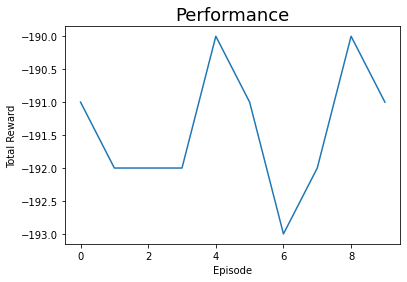

In [8]:
#CartPole
if __name__ == "__main__":
    
    env = gym.make('CartPole-v1')
    agent = DQNAgent(4,2) #แก้ได้ agent หลายๆ Improvement
    number_of_episodes = 10
    total_reward = np.zeros(number_of_episodes)
    train_freq = 2
    
    for i in tqdm_notebook(range(number_of_episodes)):
        count = 0
        state = env.reset()
        state = np.reshape(state, [1,4])
        
           
        while True:
            count += 1
            #env.render()
            
            #take action
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,4])
            
            if done: 
                reward = -200
            else:
                reward = reward
                
            agent.save_sample(state, action, reward, next_state, done)
                
            if count % train_freq == 0:
                agent.train_model()
            
            state = next_state
            total_reward[i] += reward

            if done:
                #env.render()
                
                agent.update_target_model()
    
                '''text_file = open("text.txt", "a") 
                text_file.write('{}\n'.format(total_reward[i]))
                text_file.close()'''
                
                print("Episode {}, Reward {}".format(i+1, total_reward[i]))
                
                break
        
        
    plt.plot(total_reward)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Performance',fontsize=18)
    plt.show()
    env.close()